In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from recast import Model, Weibull

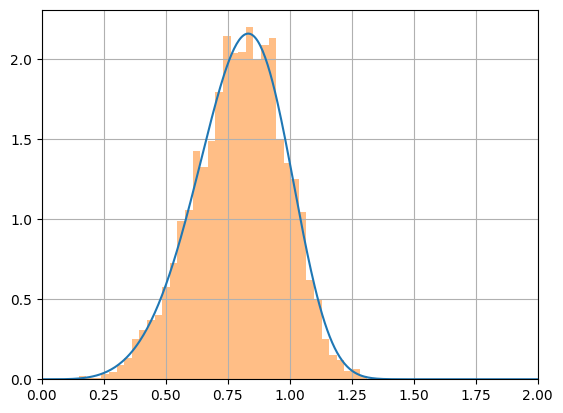

In [2]:
dist = Weibull(2.0, 5.0)
samples = dist.sample(3000)
x = tf.Variable(np.linspace(0, 5, 1000), dtype=tf.float32)
y = dist.prob(x)
plt.plot(x, y)
plt.hist(samples, density=True, bins=40, alpha=0.5)
plt.xlim([0, 2])
plt.grid()
plt.show()

### Entraînement sur les données de Shchur

In [3]:
file = open("data/shchur.pkl", "rb")
data = pickle.load(file)
t_end = data["t_end"]
arrival_times = data["arrival_times"]
seq_lengths = [len(times) for times in arrival_times]
inter_times_list = [np.diff(times, prepend=0, append=t_end)
                    for times in arrival_times]
inter_times = np.asarray([np.pad(inter_times, (0, np.max(seq_lengths) - size))
        for size, inter_times in zip(seq_lengths, inter_times_list)])
inter_times = tf.Variable(inter_times, dtype=tf.float32)

model = Model(context_size=32)
model.fit(120, inter_times, seq_lengths, t_end)

Loss at epoch 0: 1.09
Loss at epoch 10: 0.81
Loss at epoch 20: 0.80
Loss at epoch 30: 0.79
Loss at epoch 40: 0.78
Loss at epoch 50: 0.77
Loss at epoch 60: 0.76
Loss at epoch 70: 0.74
Loss at epoch 80: 0.73
Loss at epoch 90: 0.73
Loss at epoch 100: 0.73
Loss at epoch 110: 0.73
Loss at epoch 120: 0.72


### Génération de séquences

On part d'un vecteur contexte nul, d'une liste de temps d'attente
vide. On obtient la distribution du prochain temps d'attente,
on tire un temps d'attente, on calcule le nouveau
$y_j = (\tau_j, \log \tau_j)$ et on obtient le nouveau vecteur
contexte. Puis on obtient la prochaine distribution et ainsi de suite.

$(B, 1) \to (B, 1, 2) \to (B, 1, 32) \to (B, 1, 2) \to (B, 1)$ etc.

On calcule la somme cumulée des temps d'attente pour chaque séquence,
on affiche les trajectoires et les temps d'arrivée.

In [4]:
batch_size=1000
t_end = 100
arrival_times = model.sample(batch_size, t_end)
generated_data = pd.DataFrame(arrival_times).T
generated_data.iloc[:10, :5]

,0,1,2,3,4
0,3.014271,0.145394,2.878619,3.227877,2.829915
1,4.898106,3.140278,5.947636,4.373711,4.546698
2,8.621912,4.059475,6.713945,4.670234,4.548440
3,8.909388,4.300955,6.760663,7.254021,4.813782
4,9.142738,4.916889,8.799157,8.994872,4.886772
5,12.786186,5.162246,10.028896,9.198373,5.066732
6,12.826683,5.767234,11.128828,9.378346,5.160072
7,13.273529,7.348799,13.260714,9.439733,5.252392
8,13.698632,7.464891,14.445952,12.416993,6.433278
9,13.794939,7.806740,15.180430,12.592736,9.397089


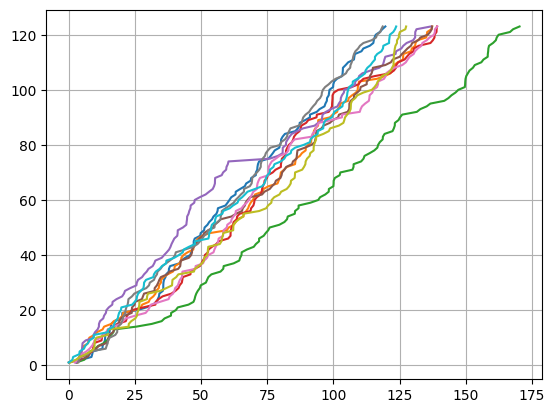

In [5]:
samples = generated_data.iloc[:, :10]
plt.plot(samples, samples.index + 1)
plt.grid()
plt.show()

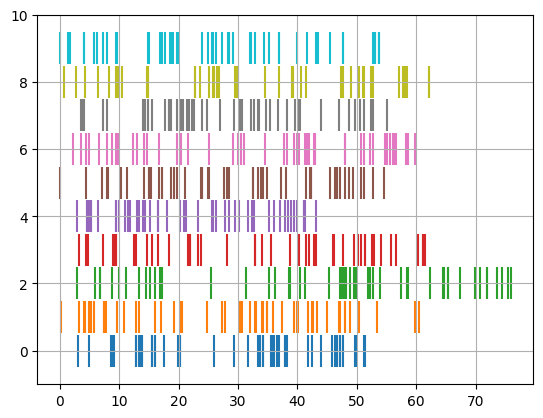

In [6]:
num_observed = 10
for i in range(num_observed):
    arr = arrival_times[i, :50]
    plt.scatter(arr, np.ones_like(arr) * i, marker="|", s=500)
plt.grid()
plt.ylim([-1, num_observed])
plt.show()

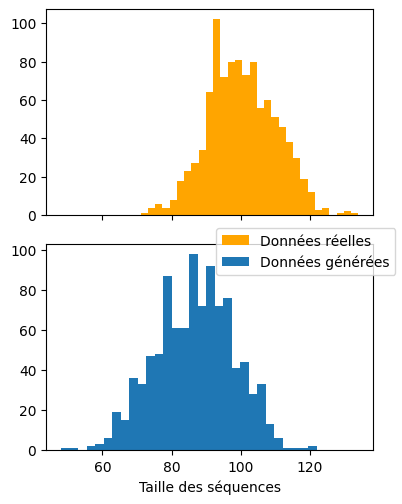

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
fig.tight_layout()

seq_lengths = [len(seq) for seq in data["arrival_times"]]
axes[0].hist(seq_lengths, bins=30, color="orange", label="Données réelles")

seq_lengths = (arrival_times < t_end).sum(axis=-1)
axes[1].hist(seq_lengths, bins=30, label="Données générées")
axes[1].set_xlabel("Taille des séquences")

fig.legend(loc="center right", ncols=1)

plt.show()

### Entraînement et génération sur nos données

(100, 981)


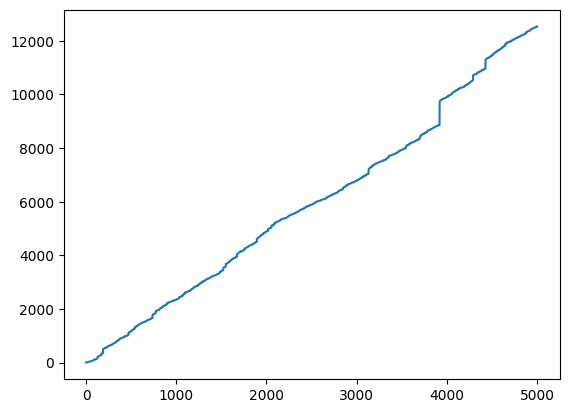

Loss at epoch 0: -0.08
Loss at epoch 10: -0.12
Loss at epoch 20: -0.12
Loss at epoch 30: -0.12
Loss at epoch 40: -0.12


In [10]:
data = pd.read_csv("data/tmax5k.csv", index_col=0)
t_end = 5000
arrival_times = data.t.to_numpy()
num_seqs = 100

# séparation en fenêtres
cuts = np.linspace(0, t_end, num_seqs + 1)
seqs = [[t for t in arrival_times if t >= cuts[i] and t < cuts[i + 1]]
         for i in range(num_seqs)]
seq_lengths = [len(seq) for seq in seqs]
inter_times_list = [np.diff(times, prepend=cuts[i], append=cuts[i+1])
               for i, times in zip(range(num_seqs), seqs)]
inter_times = [np.pad(seq, [0, np.max(seq_lengths) - size])
               for seq, size in zip(inter_times_list, seq_lengths)]
inter_times = tf.Variable(inter_times, dtype=tf.float32)

print(inter_times.shape)
plt.plot(data.t, data.index + 1)
plt.show()

# entraînement
model = Model(context_size=32)
model.fit(40, inter_times, seq_lengths, t_end)

In [11]:
batch_size = 1000
t_end = 100
arrival_times = model.sample(batch_size, t_end)

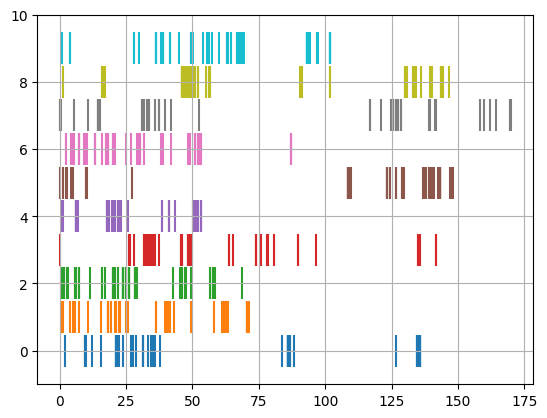

In [12]:
num_observed = 10
for i in range(num_observed):
    arr = arrival_times[i, :50]
    plt.scatter(arr, np.ones_like(arr) * i, marker="|", s=500)
plt.grid()
plt.ylim([-1, num_observed])
plt.show()